In [193]:
#import libraries
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
import plotly.express as px
import plotly.graph_objects as go





# Set display options
pd.set_option('display.max_columns', None)  # None means unlimited
pd.set_option('display.max_rows', None)  # None means unlimited
warnings.simplefilter(action="ignore", category=FutureWarning)

In [191]:
def wrangle(filepath):
    # Read csv file into dataframe
    df = pd.read_csv(filepath)
    
    # Remove duplicated values
    df.drop_duplicates(subset="id", inplace=True)
    
    # Convert date to datetime and split
    df["date"] = pd.to_datetime(df["date"])
    df["year"] = df["date"].dt.year
    df["month"] = df["date"].dt.month
    df["day"] = df["date"].dt.day


    #convert zipcode to str
    df["zipcode"] = df["zipcode"].astype("category")
    
    # Drop date and id column
    df.drop(["date", "id"], axis=1, inplace=True)

    # Drop multicolinear variables
    df.drop(["sqft_above", "sqft_basement"], axis=1, inplace=True)

    #subset price where "price_aprox_usd" < 400_000
    mask_price = df["price"] < 1_000_000

    df = df[mask_price]
    
    
    # Add other data wrangling steps here if needed
    
    return df


In [44]:
df = wrangle(r"C:\Users\eakli\Downloads\task\ecole\house-pricing-prediction\apartment-hunter\data\raw\kc_house_data.csv")

In [45]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1955,0,98178,47.5112,-122.257,1340,5650,2014,10,13
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,1951,1991,98125,47.7210,-122.319,1690,7639,2014,12,9
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,1933,0,98028,47.7379,-122.233,2720,8062,2015,2,25
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1965,0,98136,47.5208,-122.393,1360,5000,2014,12,9
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1987,0,98074,47.6168,-122.045,1800,7503,2015,2,18


In [41]:
df.shape

(21436, 20)

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21436 entries, 0 to 21612
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   price          21436 non-null  float64 
 1   bedrooms       21436 non-null  int64   
 2   bathrooms      21436 non-null  float64 
 3   sqft_living    21436 non-null  int64   
 4   sqft_lot       21436 non-null  int64   
 5   floors         21436 non-null  float64 
 6   waterfront     21436 non-null  int64   
 7   view           21436 non-null  int64   
 8   condition      21436 non-null  int64   
 9   grade          21436 non-null  int64   
 10  yr_built       21436 non-null  int64   
 11  yr_renovated   21436 non-null  int64   
 12  zipcode        21436 non-null  category
 13  lat            21436 non-null  float64 
 14  long           21436 non-null  float64 
 15  sqft_living15  21436 non-null  int64   
 16  sqft_lot15     21436 non-null  int64   
 17  year           21436 non-null  int32

In [6]:
df["price"].describe().apply("{0:,.0f}".format)

count       21,436
mean       540,529
std        367,689
min         75,000
25%        322,150
50%        450,000
75%        645,000
max      7,700,000
Name: price, dtype: object

<Axes: xlabel='price', ylabel='Count'>

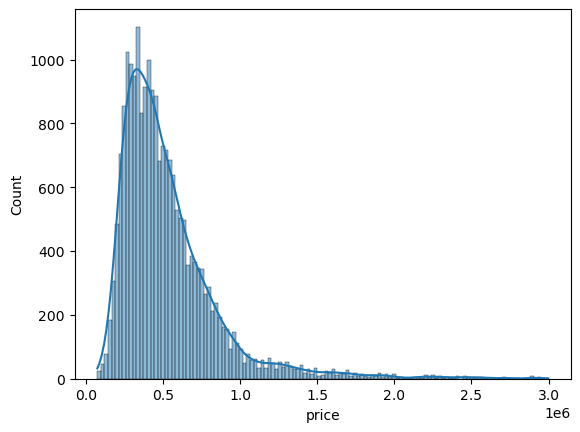

In [7]:
price_less_3e6 = df[df["price"] < 3_000_000]
price_less_3e6["sqft_living"].describe().apply("{0:,.0f}".format)
price_less_3e6["price"].describe().apply("{0:,.0f}".format)


sns.histplot(price_less_3e6["price"], kde=True)

(21238, 20)


count       21,238
mean       519,694
std        287,813
min         75,000
25%        320,000
50%        450,000
75%        635,438
max      2,000,000
Name: price, dtype: object

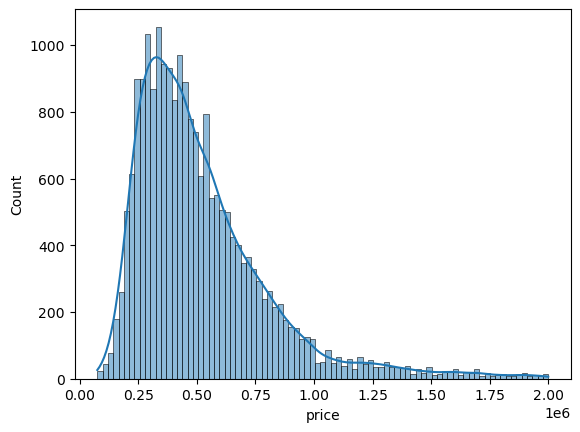

In [8]:
price_equals_less_2e6 = df[df["price"] <= 2_000_000]
price_equals_less_2e6["sqft_living"].describe().apply("{0:,.0f}".format)


sns.histplot(price_equals_less_2e6["price"], kde=True)

print(price_equals_less_2e6.shape)
price_equals_less_2e6["price"].describe().apply("{0:,.0f}".format)



(19979, 20)


count       19,979
mean       467,931
std        196,437
min         75,000
25%        314,950
50%        435,000
75%        594,000
max      1,000,000
Name: price, dtype: object

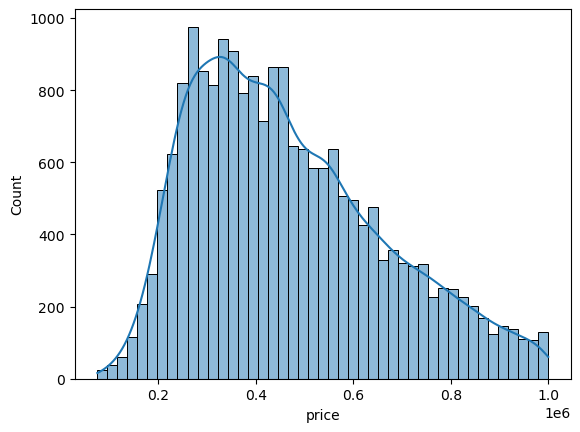

In [9]:
price_equals_less_1e6 = df[df["price"] <= 1_000_000]
price_equals_less_1e6["sqft_living"].describe().apply("{0:,.0f}".format)
# price_equals_less_1e6["price"].describe().apply("{0:,.0f}".format)


sns.histplot(price_equals_less_1e6["price"], kde=True)
print(price_equals_less_1e6.shape)

price_equals_less_1e6["price"].describe().apply("{0:,.0f}".format)


(1457, 20)


count        1,457
mean     1,536,025
std        629,958
min      1,000,750
25%      1,150,000
50%      1,325,000
75%      1,691,000
max      7,700,000
Name: price, dtype: object

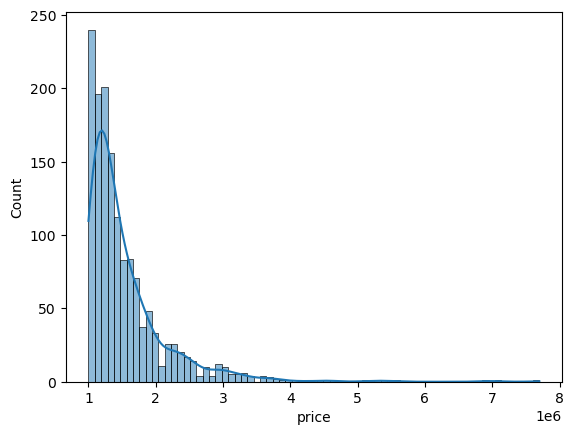

In [10]:
# Subset the dataset for houses priced above 1 million dollars
df_above_1m = df[df['price'] > 1_000_000]


sns.histplot(df_above_1m["price"], kde=True)
print(df_above_1m.shape)

df_above_1m["price"].describe().apply("{0:,.0f}".format)

(12300, 20)


count     12,300
mean     338,517
std       90,983
min       75,000
25%      269,000
50%      340,000
75%      415,000
max      499,990
Name: price, dtype: object

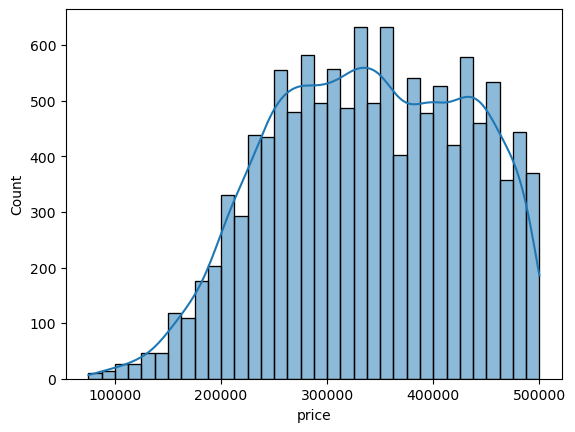

In [11]:
price_less_500K = df[df["price"] < 500_000]

price_less_500K["sqft_living"].describe().apply("{0:,.0f}".format)


sns.histplot(price_less_500K["price"], kde=True)
print(price_less_500K.shape)
price_less_500K["price"].describe().apply("{0:,.0f}".format)

(7679, 20)


count        7,679
mean       675,223
std        131,677
min        500,000
25%        562,500
50%        649,950
75%        765,500
max      1,000,000
Name: price, dtype: object

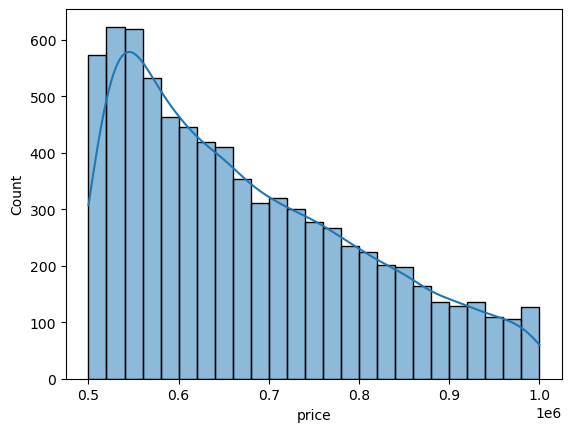

In [12]:
price_btwn_500K_and_1m = df[(df["price"] >= 500_000)  &  (df["price"] <= 1e6)]

price_btwn_500K_and_1m["sqft_living"].describe().apply("{0:,.0f}".format)


sns.histplot(price_btwn_500K_and_1m["price"], kde=True)
print(price_btwn_500K_and_1m.shape)
price_btwn_500K_and_1m["price"].describe().apply("{0:,.0f}".format)

(50, 20)


count           50
mean     3,819,715
std      1,088,118
min      3,000,000
25%      3,176,562
50%      3,397,500
75%      3,837,500
max      7,700,000
Name: price, dtype: object

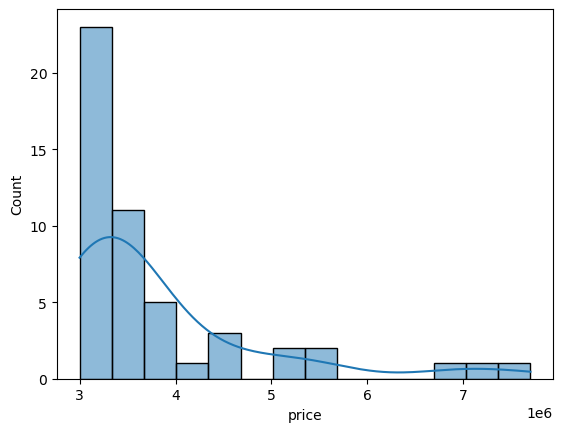

In [13]:
price_over_3e6 = df[df["price"] >= 3_000_000]
price_over_3e6["sqft_living"].describe().apply("{0:,.0f}".format)


sns.histplot(price_over_3e6["price"], kde=True)
print(price_over_3e6.shape)
price_over_3e6["price"].describe().apply("{0:,.0f}".format)


In [14]:
# Converting scientific notation to human-readable figures and discussing the market

# Given numbers
count_times_mean_above_1m = 2237988e9  # Represents count * mean price for houses above 1 million
count_times_mean_below_1m = 9348793e9  # Represents count * mean price for houses below 1 million

# Convert to human-readable numbers
human_readable_above_1m = "{:,.2f}".format(count_times_mean_above_1m)
human_readable_below_1m = "{:,.2f}".format(count_times_mean_below_1m)

(human_readable_above_1m, human_readable_below_1m)

('2,237,988,000,000,000.00', '9,348,793,000,000,000.00')

# eda house prices less than $1 million 

In [15]:
price_equals_less_1e6.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1955,0,98178,47.5112,-122.257,1340,5650,2014,10,13
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,1951,1991,98125,47.7210,-122.319,1690,7639,2014,12,9
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,1933,0,98028,47.7379,-122.233,2720,8062,2015,2,25
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1965,0,98136,47.5208,-122.393,1360,5000,2014,12,9
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1987,0,98074,47.6168,-122.045,1800,7503,2015,2,18


In [16]:
price_equals_less_1e6.shape

(19979, 20)

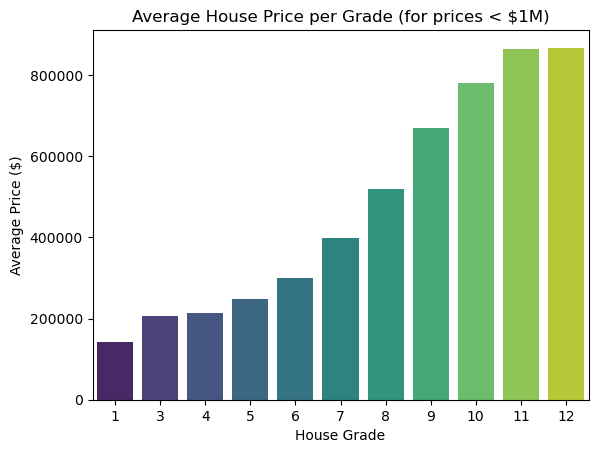

In [17]:
# Group by 'grade' and calculate the mean price, then round it

avg_price_per_grade_less_1e6 = price_equals_less_1e6.groupby("grade")["price"].mean().round()
avg_price_per_grade_less_1e6 = avg_price_per_grade_less_1e6.reset_index()


sns.barplot(
    x="grade",
    y="price",
    data=avg_price_per_grade_less_1e6,
    palette="viridis",
)

# Set the plot title and labels
plt.title('Average House Price per Grade (for prices < $1M)')
plt.xlabel('House Grade')
plt.ylabel('Average Price ($)')
plt.show()

   waterfront     price
0           0  467365.0
1           1  659007.0


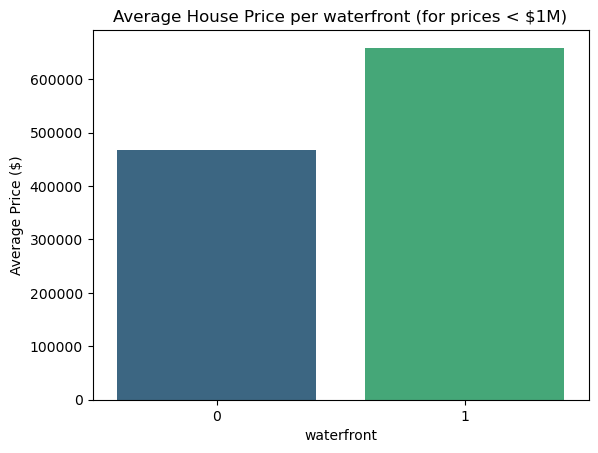

In [18]:
#Group by 'waterfront' and calculate the mean price, then round it

avg_price_per_wf_less_1e6 = price_equals_less_1e6.groupby("waterfront")["price"].mean().round()
avg_price_per_wf_less_1e6 = avg_price_per_wf_less_1e6.reset_index()

print(avg_price_per_wf_less_1e6)
sns.barplot(
    x="waterfront",
    y="price",
    data=avg_price_per_wf_less_1e6,
    palette="viridis"
)

# Set the plot title and labels
plt.title('Average House Price per waterfront (for prices < $1M)')
plt.xlabel('waterfront')
plt.ylabel('Average Price ($)')
plt.show()

   view     price
4     4  728216.0
3     3  623790.0
1     1  605550.0
2     2  602130.0
0     0  455956.0


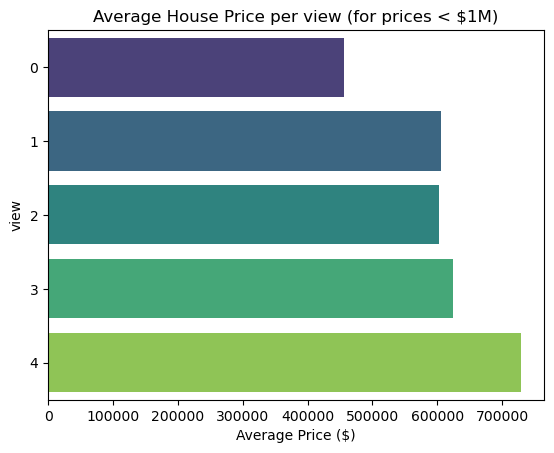

In [19]:
#Group by 'view' and calculate the mean price, then round it

avg_price_per_view_less_1e6 = price_equals_less_1e6.groupby("view")["price"].mean().round()
avg_price_per_view_less_1e6 = avg_price_per_view_less_1e6.reset_index()


# Sort the DataFrame by 'price' in descending order for a better visual distinction in the plot
avg_price_per_view_less_1e6 = avg_price_per_view_less_1e6.sort_values("price", ascending=False)

print(avg_price_per_view_less_1e6)
sns.barplot(
    x="price",
    y="view",
    data=avg_price_per_view_less_1e6,
    palette="viridis", 
    orient="h"
)

# Set the plot title and labels
plt.title('Average House Price per view (for prices < $1M)')
plt.xlabel('Average Price ($)')
plt.ylabel('view')
plt.show()

   condition     price
0          1  288855.0
1          2  305490.0
2          3  470639.0
3          4  457668.0
4          5  501644.0


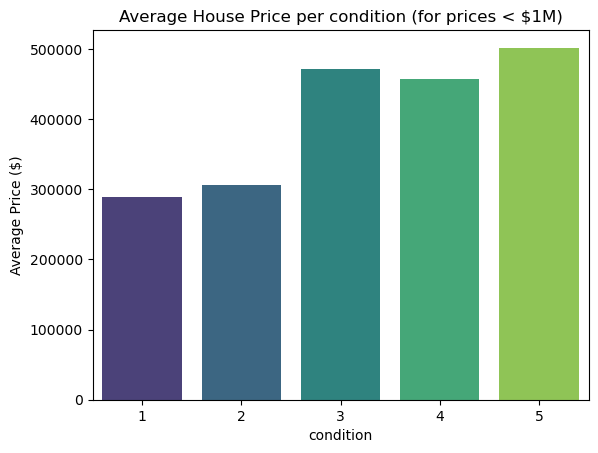

In [20]:
#Group by 'condition' and calculate the mean price, then round it

avg_price_per_condition_less_1e6 = price_equals_less_1e6.groupby("condition")["price"].mean().round()
avg_price_per_condition_less_1e6 = avg_price_per_condition_less_1e6.reset_index()

print(avg_price_per_condition_less_1e6)
sns.barplot(
    x="condition",
    y="price",
    data=avg_price_per_condition_less_1e6,
    palette="viridis"
)

# Set the plot title and labels
plt.title('Average House Price per condition (for prices < $1M)')
plt.xlabel('condition')
plt.ylabel('Average Price ($)')
plt.show()

## zipcode analysis

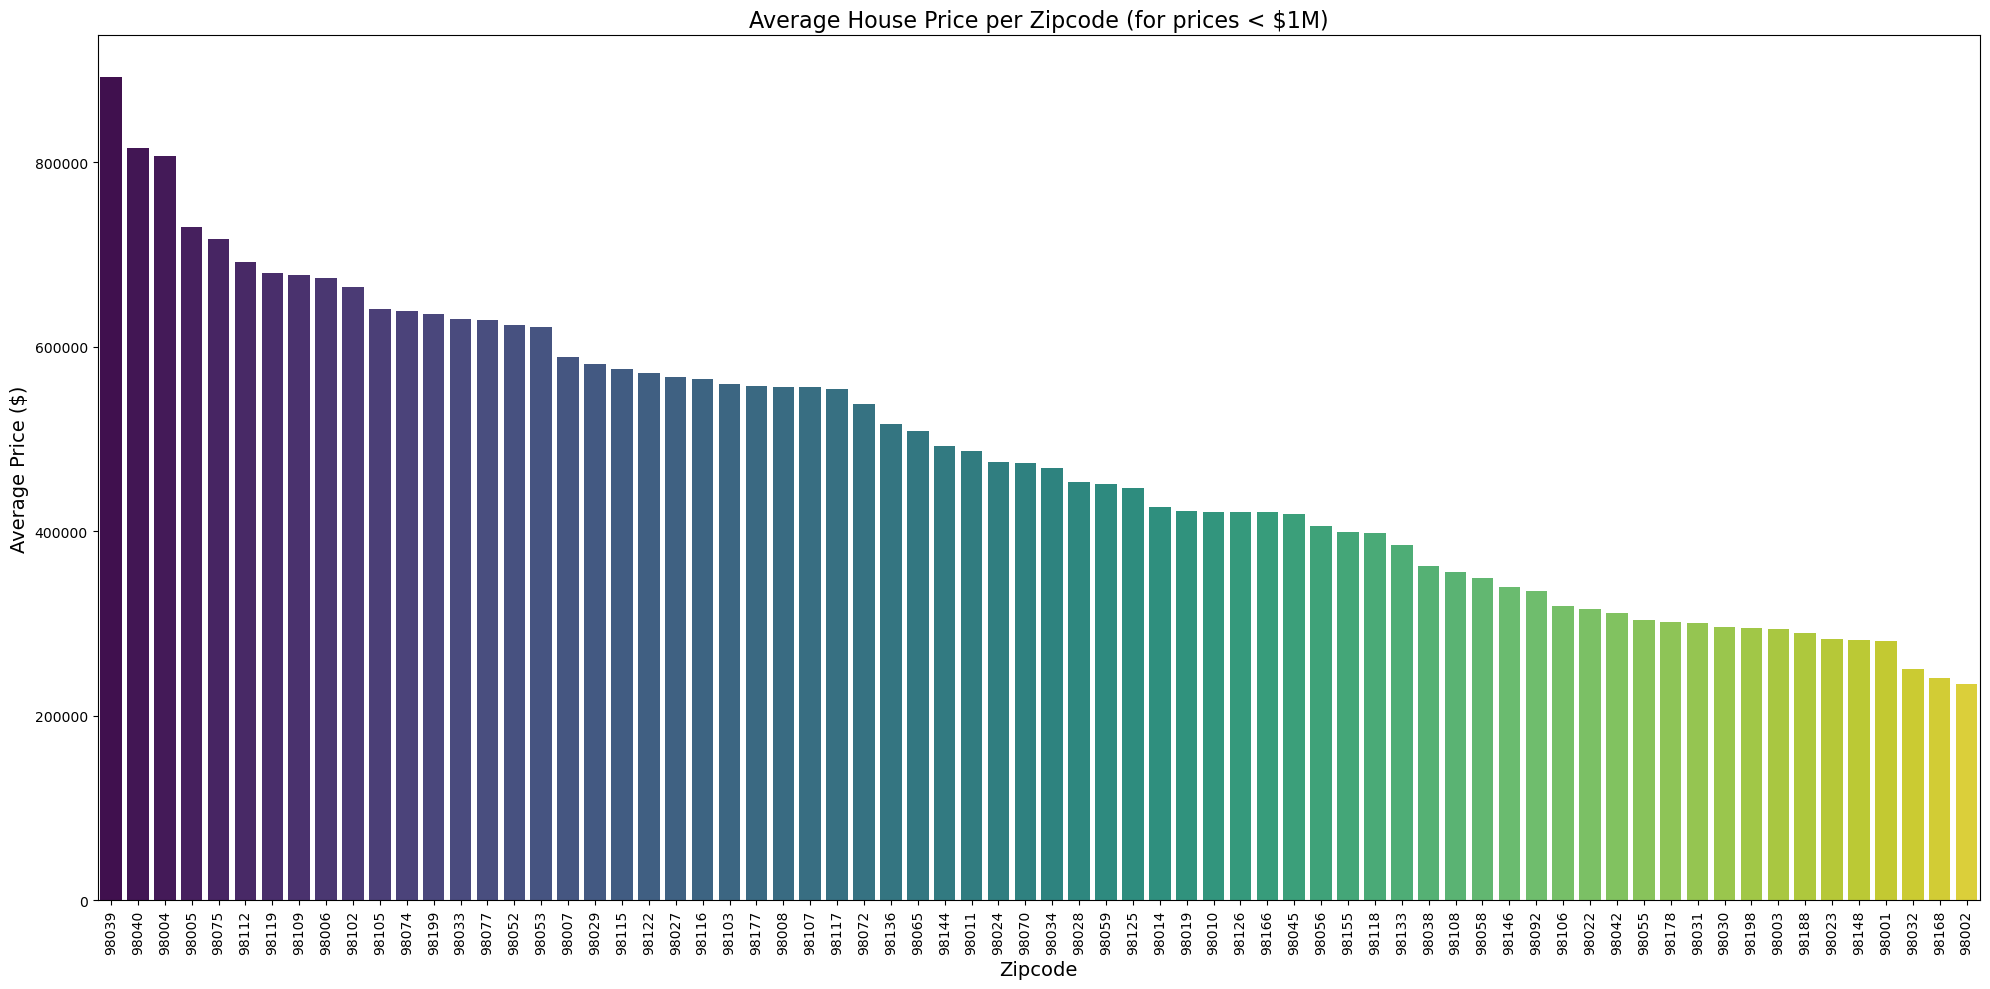

In [21]:
# Group by 'zipcode' and calculate the mean price, then round it

avg_price_per_zipcode_less_1e6 = price_equals_less_1e6.groupby("zipcode")["price"].mean().round()
avg_price_per_zipcode_less_1e6 = avg_price_per_zipcode_less_1e6.reset_index()


# Convert 'zipcode' to string as it's not already but to be included in the wrangle function
avg_price_per_zipcode_less_1e6['zipcode'] = avg_price_per_zipcode_less_1e6['zipcode'].astype(str)
# avg_price_per_zipcode_less_1e6 = avg_price_per_zipcode_less_1e6.sort_values("price", ascending=False)

# Assuming avg_price_per_zipcode_less_1e6 is defined and contains the average prices per zipcode

# Increase the size of the plot
plt.figure(figsize=(20, 10))

# Create a bar plot
sns.barplot(
    x='zipcode',
    y='price',
    data=avg_price_per_zipcode_less_1e6.sort_values('price', ascending=False),  # Sort values for better visualization
    palette='viridis'
)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=90, fontsize=10)

# Set the plot title and labels with larger font size
plt.title('Average House Price per Zipcode (for prices < $1M)', fontsize=16)
plt.xlabel('Zipcode', fontsize=14)
plt.ylabel('Average Price ($)', fontsize=14)

# Show the plot
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
plt.show()


In [62]:

avg_price_per_zipcode_less_1e6 = price_equals_less_1e6.groupby("zipcode")["price"].mean().round()
avg_price_per_zipcode_less_1e6 = avg_price_per_zipcode_less_1e6.sort_values(ascending=False).reset_index()

# Calculate average view rating per zipcode
avg_view_per_zipcode = price_equals_less_1e6.groupby("zipcode")["view"].mean().round().astype(int)
# avg_view_per_zipcode.sort_values(ascending=False)


# Calculate average grade per zipcode
avg_grade_per_zipcode = price_equals_less_1e6.groupby("zipcode")["grade"].mean().round().astype(int)
# avg_grade_per_zipcode.sort_values(ascending=False)

# Calculate average condition per zipcode
avg_condition_per_zipcode = price_equals_less_1e6.groupby("zipcode")["condition"].mean().astype(int)
# avg_condition_per_zipcode.sort_values(ascending=False)

# Calculate waterfront presence per zipcode
avg_waterfront_per_zipcode = price_equals_less_1e6.groupby("zipcode")["waterfront"].mean().astype(int)
# avg_waterfront_per_zipcode.sort_values(ascending=False)

# Calculate waterfront presence per zipcode
avg_floor_per_zipcode = price_equals_less_1e6.groupby("zipcode")["floors"].mean().astype(int)
# avg_waterfront_per_zipcode.sort_values(ascending=False)


# Merge these into a single DataFrame
zipcode_analysis = avg_price_per_zipcode_less_1e6.set_index("zipcode").join([
    avg_view_per_zipcode,
    avg_grade_per_zipcode,
    avg_condition_per_zipcode,
    avg_waterfront_per_zipcode,
    avg_floor_per_zipcode

], how="inner")


zipcode_analysis.columns = [
    'Average Price', 
    'Average View', 
    'Average Grade', 
    'Average Condition', 
    'Waterfront Presence',
    'Average Floors'
]

# Display the DataFrame
zipcode_analysis.sort_values('Average Price', ascending=False, inplace=True)
print(zipcode_analysis.shape)

zipcode_analysis






(70, 6)


,Average Price,Average View,Average Grade,Average Condition,Waterfront Presence,Average Floors
zipcode,,,,,,
98039,893000.0,0,7,3,0,1
98040,815540.0,0,8,3,0,1
98004,806751.0,0,8,3,0,1
98005,729715.0,0,8,3,0,1
98075,717211.0,0,9,3,0,1
98112,692255.0,0,8,3,0,1
98119,680459.0,0,8,3,0,1
98109,677664.0,0,8,3,0,1
98006,674428.0,0,8,3,0,1


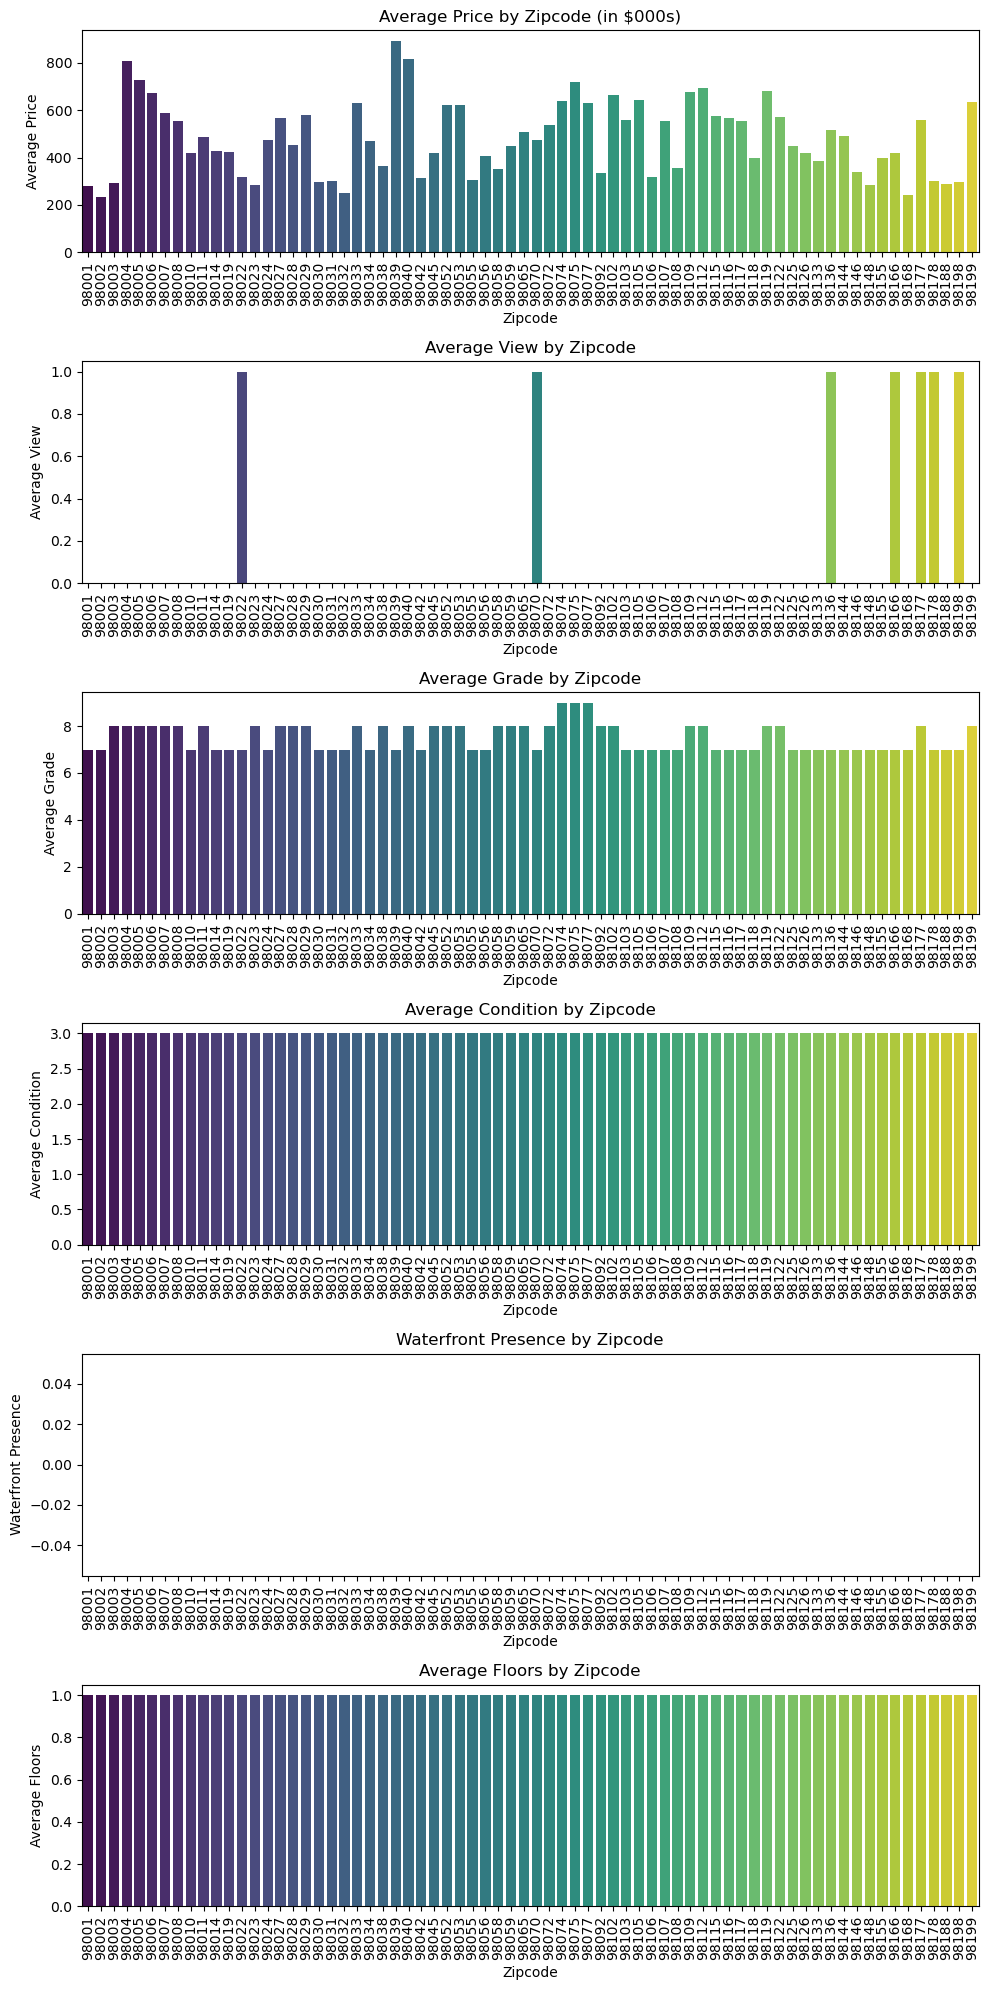

In [63]:
#normalise the price for better visualisation
zipcode_analysis["Average Price"] /= 1000  # in '000s

#creat a fig with subplots
fig, axs = plt.subplots(6,1, figsize=(10,20))

#PLOT avearge price
sns.barplot(x=zipcode_analysis.index, y="Average Price", data=zipcode_analysis, ax=axs[0], palette="viridis")
axs[0].set_title('Average Price by Zipcode (in $000s)')
axs[0].set_xlabel('Zipcode')
axs[0].set_ylabel('Average Price')


# Plot Average View
sns.barplot(x=zipcode_analysis.index, y='Average View', data=zipcode_analysis, ax=axs[1], palette='viridis')
axs[1].set_title('Average View by Zipcode')
axs[1].set_xlabel('Zipcode')
axs[1].set_ylabel('Average View')

# Plot Average Grade
sns.barplot(x=zipcode_analysis.index, y='Average Grade', data=zipcode_analysis, ax=axs[2], palette='viridis')
axs[2].set_title('Average Grade by Zipcode')
axs[2].set_xlabel('Zipcode')
axs[2].set_ylabel('Average Grade')

# Plot Average Condition
sns.barplot(x=zipcode_analysis.index, y='Average Condition', data=zipcode_analysis, ax=axs[3], palette='viridis')
axs[3].set_title('Average Condition by Zipcode')
axs[3].set_xlabel('Zipcode')
axs[3].set_ylabel('Average Condition')

# Plot Waterfront Presence
sns.barplot(x=zipcode_analysis.index, y='Waterfront Presence', data=zipcode_analysis, ax=axs[4], palette='viridis')
axs[4].set_title('Waterfront Presence by Zipcode')
axs[4].set_xlabel('Zipcode')
axs[4].set_ylabel('Waterfront Presence')


# Plot  Average Floors 
sns.barplot(x=zipcode_analysis.index, y='Average Floors', data=zipcode_analysis, ax=axs[5], palette='viridis')
axs[5].set_title('Average Floors by Zipcode')
axs[5].set_xlabel('Zipcode')
axs[5].set_ylabel('Average Floors')

#rotate the x-axis labels:
for ax in axs:
    plt.sca(ax)
    plt.xticks(rotation=90)


# Automatically adjust the subplot layout for a clean look
plt.tight_layout()

# Display the plots
plt.show()


In [23]:
price_equals_less_1e6_with_wf = price_equals_less_1e6[price_equals_less_1e6["waterfront"] == 1]

In [24]:
price_equals_less_1e6_with_wf.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day
230,655000.0,2,1.75,1450,15798,2.0,1,4,3,7,1915,1978,98166,47.4497,-122.375,2030,13193,2015,4,13
264,369900.0,1,0.75,760,10079,1.0,1,4,5,5,1936,0,98070,47.4683,-122.438,1230,14267,2014,10,27
457,705000.0,3,3.00,1970,20978,2.0,1,3,4,9,1980,0,98070,47.3844,-122.438,2280,75396,2014,11,26
1081,825000.0,2,1.00,1150,12775,1.0,1,4,4,6,1908,0,98178,47.5020,-122.222,2440,11852,2014,8,27
1157,790000.0,4,1.75,2460,10061,1.0,1,4,3,7,1961,0,98178,47.5105,-122.238,2300,10061,2014,12,29


In [25]:
price_equals_less_1e6_with_wf.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day
count,59.000000,59.000000,59.000000,59.00000,59.000000,59.000000,59.0,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000
mean,659007.491525,2.813559,1.961864,1989.20339,33659.169492,1.423729,1.0,3.627119,3.593220,7.254237,1948.983051,471.288136,98121.474576,47.435134,-122.374729,1955.627119,28266.288136,2014.254237,6.949153,19.067797
std,205554.327899,1.041792,0.892755,794.42744,67856.669032,0.498390,0.0,0.692280,0.768309,1.138560,24.219892,852.217757,58.505336,0.069751,0.094117,576.894716,31486.952867,0.439169,3.245282,7.910849
min,285000.000000,1.000000,0.750000,440.00000,1989.000000,1.000000,1.0,1.000000,1.000000,5.000000,1903.000000,0.000000,98006.000000,47.327600,-122.514000,750.000000,2433.000000,2014.000000,1.000000,1.000000
25%,511500.000000,2.000000,1.000000,1455.00000,11390.000000,1.000000,1.0,3.000000,3.000000,6.500000,1930.000000,0.000000,98070.000000,47.379050,-122.445500,1605.000000,11897.000000,2014.000000,4.500000,13.000000
50%,650000.000000,3.000000,1.750000,1990.00000,17635.000000,1.000000,1.0,4.000000,4.000000,7.000000,1950.000000,0.000000,98136.000000,47.449900,-122.377000,1970.000000,16630.000000,2014.000000,7.000000,20.000000
75%,810000.000000,3.000000,2.500000,2520.00000,27962.500000,2.000000,1.0,4.000000,4.000000,8.000000,1965.000000,0.000000,98178.000000,47.498250,-122.324500,2345.000000,32193.500000,2014.500000,10.000000,27.000000
max,1000000.000000,6.000000,4.500000,4380.00000,505166.000000,3.000000,1.0,4.000000,5.000000,10.000000,2007.000000,2003.000000,98198.000000,47.645000,-122.084000,3270.000000,192268.000000,2015.000000,12.000000,30.000000


<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


<Axes: xlabel='waterfront', ylabel='Count'>

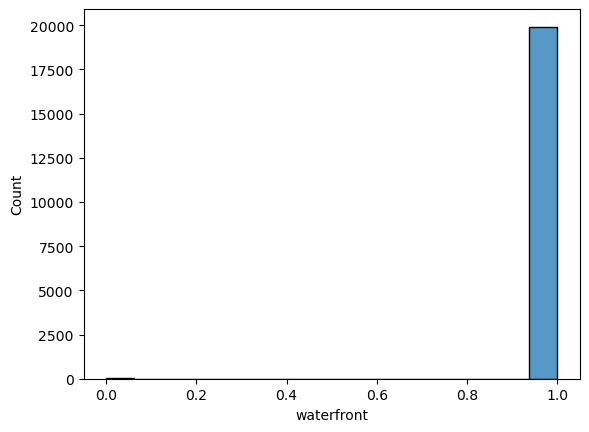

In [67]:
sns.histplot(price_equals_less_1e6["waterfront"]== 0)

In [77]:
price_equals_less_1e6.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1955,0,98178,47.5112,-122.257,1340,5650,2014,10,13
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,1951,1991,98125,47.7210,-122.319,1690,7639,2014,12,9
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,1933,0,98028,47.7379,-122.233,2720,8062,2015,2,25
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1965,0,98136,47.5208,-122.393,1360,5000,2014,12,9
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1987,0,98074,47.6168,-122.045,1800,7503,2015,2,18


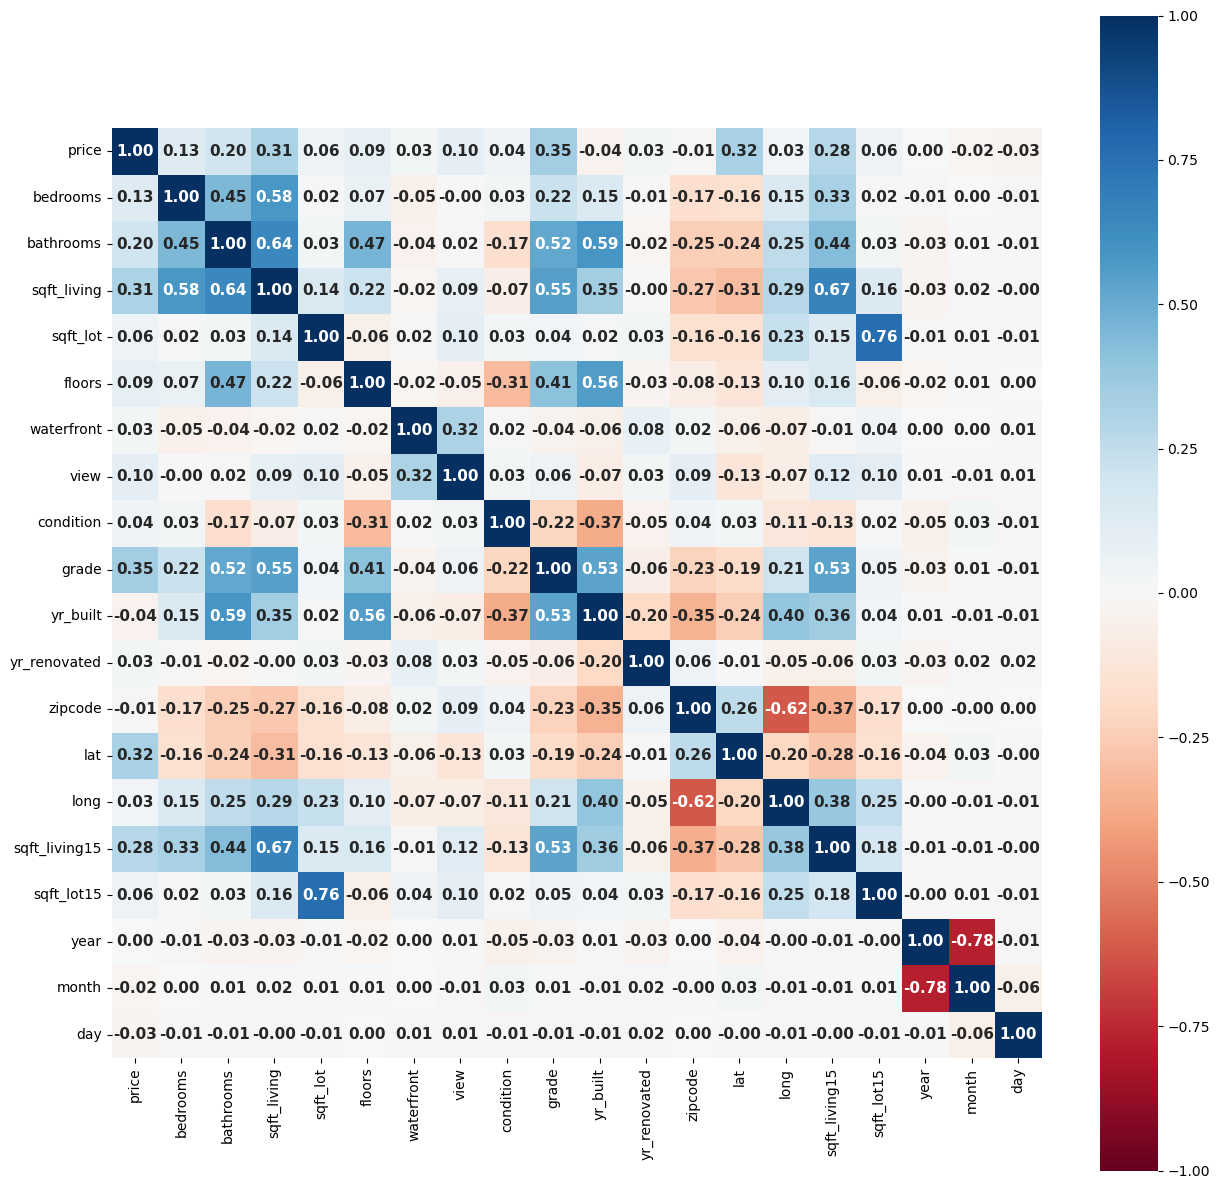

In [113]:
fig, ax = plt.subplots(figsize=(15,15))   

sns.heatmap(price_equals_less_1e6.corr(), cmap="RdBu", fmt=".2f", square=True,  
            annot=True, vmin=-1, vmax=1, ax=ax, annot_kws={"fontsize": 11, "fontweight": "bold"})
plt.show()

In [95]:
price_equals_less_1e6.describe()[["sqft_living", "sqft_living15"]]

,sqft_living,sqft_living15
count,12880.000000,12880.000000
mean,1903.013820,1868.257919
std,643.088106,504.295944
min,410.000000,399.000000
25%,1430.000000,1480.000000
50%,1840.000000,1800.000000
75%,2300.000000,2200.000000
max,5461.000000,4362.000000


<Axes: xlabel='sqft_living', ylabel='Count'>

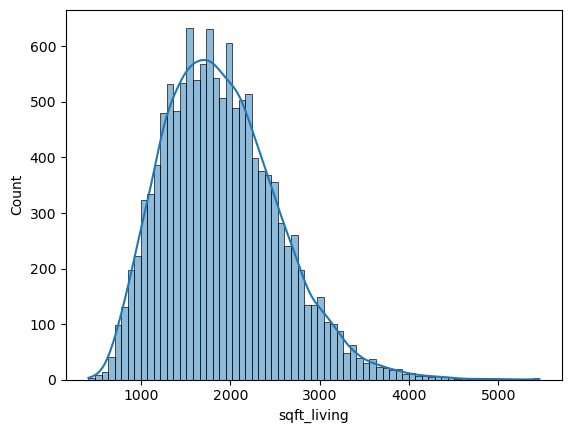

In [120]:
sns.histplot(price_equals_less_1e6["sqft_living"], kde=True)

Text(0.5, 1.0, 'price vs area')

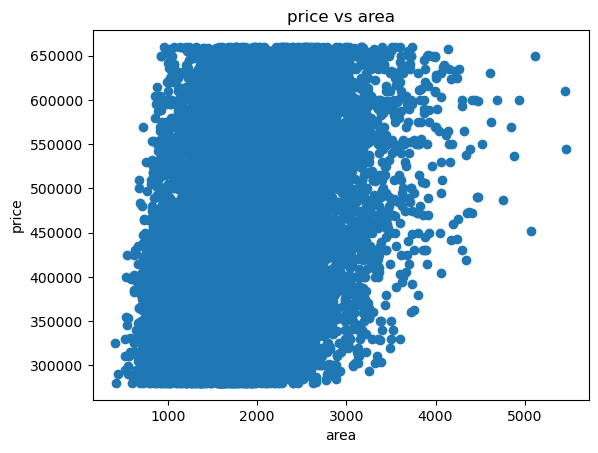

In [134]:
plt.scatter(x=price_equals_less_1e6["sqft_living"], y=price_equals_less_1e6["price"])
plt.xlabel("area")
plt.ylabel("price")
plt.title("price vs area")

In [138]:
features = ["sqft_living"]
X_train = price_equals_less_1e6[features]
target = "price"
y_train = price_equals_less_1e6[target]
y_train.shape

(12880,)

# Build Model
## Baseline
The first step in building a model is baselining. To do this, ask yourself how you will know if the model you build is performing well?" One way to think about this is to see how a "dumb" model would perform on the same data. Some people also call this a naïve or baseline model, but it's always a model makes only one prediction — in this case, it predicts the same price regardless of an apartment's size. So let's start by figuring out what our baseline model's prediction should be. 

In [139]:
y_mean = y_train.mean()
y_mean

444697.3083850932

In [152]:
y_predict_baseline = [y_mean] * len(y_train)
len(y_predict_baseline)

12880

In [163]:
len(X_train)

12880

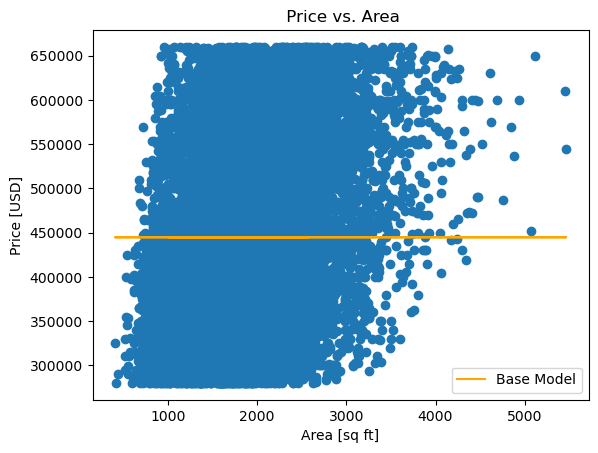

In [165]:
plt.plot(X_train, y_predict_baseline, color="orange", label="Base Model")
plt.scatter(X_train, y_train)
plt.xlabel("Area [sq ft]")
plt.ylabel("Price [USD]")
plt.title(" Price vs. Area")
plt.legend()

In [168]:
mae_baseline = mean_absolute_error(y_train, y_predict_baseline)

print("Mean apt price: ", round(y_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean apt price:  444697.31
Baseline MAE: 89864.97


What does this information tell us? If we always predicted that an apartment price is  $444,697.31, our predictions would be off by an average of $89,864.97. It also tells us that our model needs to have mean absolute error below $89,864.97 in order to be useful. 

## Iterate

In [171]:
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

LinearRegression()

## Evaluate

In [172]:
y_pred_training = lin_model.predict(X_train)
y_pred_training[:5]

array([478949.7046147 , 447623.77564842, 433244.66071308, 401405.19192769,
       444028.99691459])

In [174]:
mae_training = mean_absolute_error(y_train, y_pred_training)
print("Training MAE:", round(mae_training, 2))

Training MAE: 84494.44


In [181]:
intercept = lin_model.intercept_
print("Model Intercept:", intercept)

coefficient = lin_model.coef_[0]
print('Model coefficient for "surface_covered_in_feet":', round(coefficient,2))

Model Intercept: 346969.97110104334
Model coefficient for "surface_covered_in_feet": 51.35


In [185]:
print(f"apt_price = {intercept} + {coefficient} * surface_covered > ( y = b + mx)")

apt_price = 346969.97110104334 + 51.35398191192811 * surface_covered > ( y = b + mx)


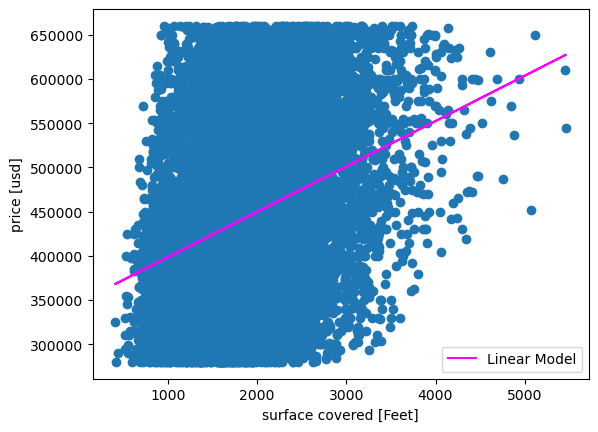

In [190]:
plt.plot(X_train, lin_model.predict(X_train), color="magenta", label="Linear Model")
plt.scatter(X_train, y_train)
plt.xlabel("surface covered [Feet]")
plt.ylabel("price [usd]")
plt.legend()

In [195]:
price_equals_less_1e6.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'yr_built', 'yr_renovated',
       'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'year',
       'month', 'day'],
      dtype='object')

In [197]:
fig = px.scatter_mapbox(
    df,  # Our DataFrame
    lat="lat",
    lon="long",
    width=600,  # Width of map
    height=600,  # Height of map
    color="price",
    hover_data=["price"],  # Display price when hovering mouse over house
)

fig.update_layout(mapbox_style="open-street-map")

fig.show()

In [148]:
# Calculate IQR for "price"
price_Q1 = price_equals_less_1e6["price"].quantile(0.25)
price_Q3 = price_equals_less_1e6["price"].quantile(0.75)
price_IQR = price_Q3 - price_Q1
lower_bound = price_Q1 - (1.5 * price_IQR)
upper_bound = price_Q3 + (1.5 * price_IQR)

# Print the bounds to check them
print('Lower Bound:', lower_bound)
print('Upper Bound:', upper_bound)

# Find outliers
outliers_df = price_equals_less_1e6[(price_equals_less_1e6["price"] < lower_bound) | (price_equals_less_1e6["price"] > upper_bound)]

# Check if outliers_df is empty
if outliers_df.empty:
    print("No outliers based on the given criteria.")
else:
    # Describe the price column in outliers_df
    print(outliers_df["price"].describe().apply(lambda x: "{0:,.0f}".format(x)))


Lower Bound: 159750.0
Upper Bound: 720150.0
No outliers based on the given criteria.


Once your model is built and tested, it's time to share it with others. If you're presenting to simple linear model to a technical audience, they might appreciate an equation. When we created our baseline model, we represented it as a line. The equation for a line like this is usually written as:

<center>"Equation: y = m*x + b"</center>

Since data scientists often work with more complicated linear models, they prefer to write the equation as:

<center> "Equation: y = beta 0 + beta 1 * x" </center>

Regardless of how we write the equation, we need to find the values that our model has determined for the intercept and and coefficient. Fortunately, all trained models in scikit-learn store this information in the model itself. Let's start with the intercept.

In [149]:
# Calculate IQR for "price"
price_Q1 = df["price"].quantile(0.25)
price_Q3 = df["price"].quantile(0.75)
price_IQR = price_Q3 - price_Q1
lower_bound = price_Q1 - (1.5 * price_IQR)
upper_bound = price_Q3 + (1.5 * price_IQR)

# Print the bounds to check them
print('Lower Bound:', lower_bound)
print('Upper Bound:', upper_bound)

# Find outliers
outliers_df = df[(df["price"] < lower_bound) | (df["price"] > upper_bound)]

# Check if outliers_df is empty
if outliers_df.empty:
    print("No outliers based on the given criteria.")
else:
    # Describe the price column in outliers_df
    print(outliers_df["price"].describe().apply(lambda x: "{0:,.0f}".format(x)))


Lower Bound: 147500.0
Upper Bound: 775500.0
No outliers based on the given criteria.


In [142]:
#remove outliers by surface area covered
low, high = price_equals_less_1e6["price"].quantile([0.1, 0.9])
mask_area = price_equals_less_1e6["price"].between(low, high)
price_equals_less_1e6 = price_equals_less_1e6[mask_area]
price_equals_less_1e6["price"].describe().apply("{0:,.0f}".format)

count     10,421
mean     440,795
std       82,892
min      310,000
25%      369,900
50%      435,000
75%      510,000
max      600,000
Name: price, dtype: object

In [28]:
# Handling outliers for 'price' - here we are just checking for extreme values
price_Q1 = df['price'].quantile(0.25)
price_Q3 = df['price'].quantile(0.75)
price_IQR = price_Q3 - price_Q1
lower_bound = price_Q1 - (1.5 * price_IQR)
upper_bound = price_Q3 + (1.5 * price_IQR)
outliers_df = df[(df['price'] < lower_bound) | (df['price'] > upper_bound)]

# Dropping the extreme outliers for 'price'
df = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]

# Checking the new shape of the dataset after cleaning
new_shape = df.shape

In [29]:
# # Convert 'zipcode' to a string format
# df['zipcode'] = df['zipcode'].astype(str)

In [30]:
zipcode_avg_price = df.groupby('zipcode')['price'].mean()#.sort_values(ascending=False)


In [31]:
# Prepare the data for feature enginnering
geo_data = df[['zipcode', 'lat', 'long']].drop_duplicates()
geo_data['avg_price'] = geo_data['zipcode'].map(zipcode_avg_price)

# Scale the features
scaler = StandardScaler()
geo_data_scaled = scaler.fit_transform(geo_data[['lat', 'long', 'avg_price']])

# Apply K-Means Clustering
kmeans = KMeans(n_clusters=5, random_state=42)
geo_data['cluster'] = kmeans.fit_predict(geo_data_scaled)

# Create a mapping from zipcode to cluster
zipcode_to_cluster = geo_data.set_index('zipcode')['cluster'].to_dict()

# Map the geographic groupings back to the original properties
df['geo_group'] = df['zipcode'].map(zipcode_to_cluster)


In [32]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day,geo_group
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1955,0,98178,47.5112,-122.257,1340,5650,2014,10,13,3
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,1951,1991,98125,47.7210,-122.319,1690,7639,2014,12,9,2
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,1933,0,98028,47.7379,-122.233,2720,8062,2015,2,25,2
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1965,0,98136,47.5208,-122.393,1360,5000,2014,12,9,2
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1987,0,98074,47.6168,-122.045,1800,7503,2015,2,18,1


In [33]:
# Assuming df is your DataFrame and 'bathrooms' is the column of interest
df['full_bathrooms'] = df['bathrooms'].apply(lambda x: int(x))  # Full bathrooms are the integer part
df['half_bathrooms'] = df['bathrooms'].apply(lambda x: (x - int(x)) * 2)  # Half bathrooms are the fractional part, multiplied by 2

# Create a feature for unusual bathroom counts
df['unusual_bath_count'] = df['bathrooms'].isin([0, 0.75]).astype(int)

# Investigate properties with 0 bathrooms
properties_with_no_bathrooms = df[df['bathrooms'] == 0]

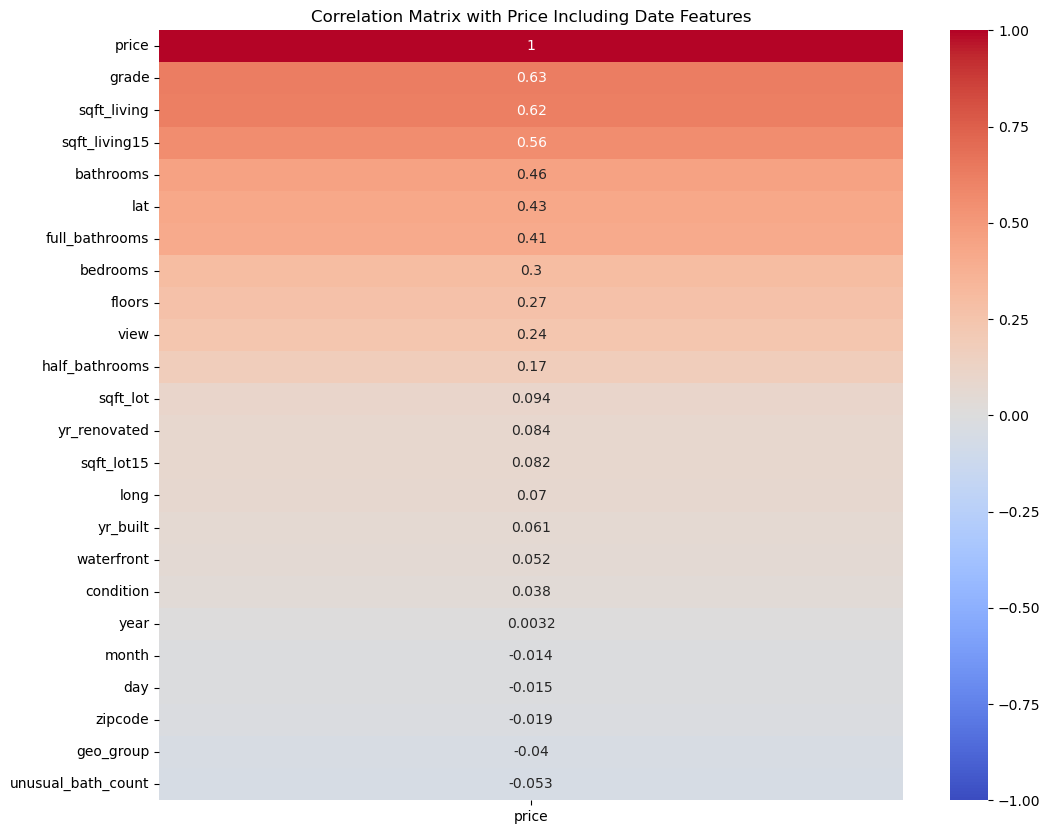

In [34]:
corr_matrix = df.corr()


plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix[['price']].sort_values(by='price', ascending=False), 
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix with Price Including Date Features')
plt.show()

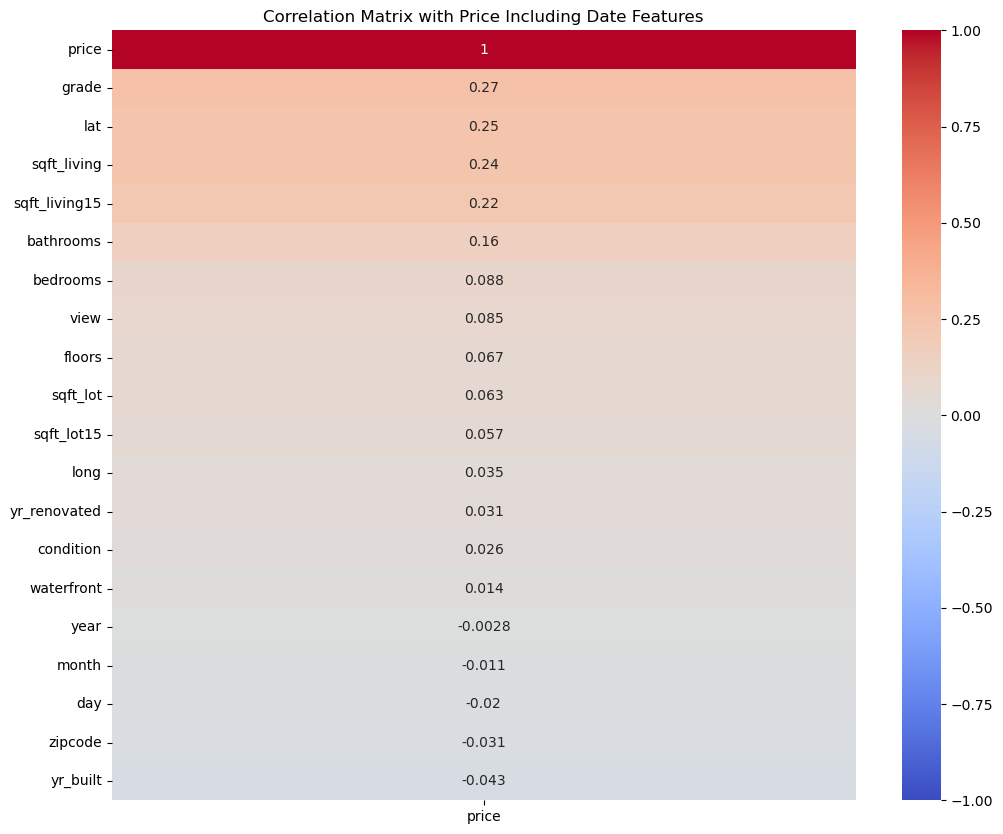

In [192]:
corr_matrix = price_equals_less_1e6.corr()


plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix[['price']].sort_values(by='price', ascending=False), 
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix with Price Including Date Features')
plt.show()